# Clustering evaluation on high dimensional data using graph clustering

Graph construction: larger neighborhood + keep only edges supported by a number of triangles

In [36]:
!git branch

* main


In [37]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [38]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn import cluster

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
from sklearn.neighbors import KNeighborsTransformer
import pynndescent
import itertools
import collections
from scipy.spatial.distance import euclidean

from partition_igraph import community_ecg as ecg
from community import community_louvain, modularity
import leidenalg as la
import igraph as ig

sns.set()

# MNIST, USPS and Pendigits are easy

We can use the sklearn API to fetch data for the Pendigits, MNIST and USPS datasets.

Of these datasets pendigits is the smallest, with only 1797 samples, and is only 64 dimensional. This makes a good first dataset to test things out on -- the dataset is small enough that practically anything should be able to run on this efficiently.

USPS provides a slightly more challenging dataset, with almost 10,000 samples and 256 dimensions, but is still samall enough to be tractable for even naive clustering implementations.

MNIST provides a good basic scaling test with 70,000 samples in 784 dimensions. In practice this is not a very large dataset compared to many that people want to cluster, although the dimensionality may provide some challenges.

# Clustering metric eval

To make things easier later we will write some short functions to evaluate clusterings (with some special handling of singleton clusters or noise points for clusterign algorithms that support such things), and to plot the results for easy comparison.

In [39]:
def eval_clusters(cluster_labels0, true_labels, raw_data, cluster_method="None", min_cluster_size=1):
    cluster_labels = cluster_labels0.copy()
    unique_labels = np.unique(cluster_labels)
    cluster_sizes, size_ids = np.histogram(cluster_labels, bins=unique_labels)
    if np.any(cluster_sizes <= min_cluster_size): # Has singleton clusters -- call them noise
        singleton_clusters = size_ids[:-1][cluster_sizes < min_cluster_size]
        for c in singleton_clusters:
            cluster_labels[cluster_labels == c] = -1
    if (np.any(cluster_labels < 0)): # Has noise points
        clustered_points = (cluster_labels >= 0)
        ari = adjusted_rand_score(true_labels[clustered_points], cluster_labels[clustered_points])
        ami = adjusted_mutual_info_score(true_labels[clustered_points], cluster_labels[clustered_points])
        #sil = silhouette_score(raw_data[clustered_points], cluster_labels[clustered_points])
        pct_clustered = (np.sum(clustered_points) / cluster_labels.shape[0])
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}\nPct clustered: {pct_clustered * 100:.2f}%")
    else:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        ami = adjusted_mutual_info_score(true_labels, cluster_labels)
        #sil = silhouette_score(raw_data, cluster_labels)
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}")
        pct_clustered = 1.0
    
    return {"Method": cluster_method, "ARI": ari, "AMI": ami, "Pct Clustered": pct_clustered}
#return {"Method": cluster_method, "ARI": ari, "AMI": ami, "Silhouette": sil, "Pct Clustered": pct_clustered}

In [5]:
def plot_scores(results_dataframe, score_types=("ARI", "AMI"), colors=list(sns.color_palette()), width=0.75, by='Dim Reduction', baselines=None):
    if(baselines is not None):
        if(len(score_types)!=len(baselines)):
            raise ValueError('Need to same length for score_types and baselines')
    else:
        baselines = [0]*len(score_types)
    fig, axs = plt.subplots(1, len(score_types), figsize=(8 * len(score_types), 8))
    x_ticklabels = results_dataframe.Method.unique()
    x_positions = np.arange(len(x_ticklabels), dtype=np.float32) - width / 2
    dim_red_types = results_dataframe[by].unique()
    bar_width = width / len(dim_red_types)
    for offset_idx, dim_red in enumerate(dim_red_types):
        color = colors[offset_idx]
        for i, score_type in enumerate(score_types):
            sub_dataframe = results_dataframe[
                (results_dataframe["Score Type"] == score_type) &
                (results_dataframe[by] == dim_red)
            ]
            nb_method = sub_dataframe.shape[0]
            axs[i].bar(
                x=x_positions[:nb_method],
                height=sub_dataframe["Score"],
                width=bar_width,
                align="edge",
                color=[(*color, v) for v in sub_dataframe["Pct Clustered"]],
                label=dim_red if i ==0 else None,
            )
            axs[i].set_xlabel("Cluster Method")
            axs[i].set_xticks(np.arange(len(x_ticklabels)))
            axs[i].set_xticklabels(x_ticklabels)
            axs[i].set_ylabel(f"{score_type} Score")
            axs[i].set_title(score_type, fontsize=20)
            axs[i].grid(visible=False, axis="x")
            axs[i].set_ylim([0, 1.05])
        x_positions[:nb_method] = x_positions[:nb_method] + bar_width
        x_positions[nb_method:] = x_positions[nb_method:] + 0.5*bar_width
    for i in range(len(score_types)):
        axs[i].axhline(baselines[i])
        
    if len(dim_red_types) > 1:
        fig.legend(loc="center right", bbox_to_anchor=(1.125, 0.5), borderaxespad=0.0, fontsize=20)
        
    fig.tight_layout()

In [6]:
def run_graph_clustering_algorithm(algo_list, G, weight = 'weight'):
    clusterings = dict()
    for algo in algo_list:
        #print(f"Running {algo}...")
        if algo == 'Louvain':
            clusterings[algo] = G.community_multilevel()
        elif algo == 'Louvain \n+ weight':
            clusterings[algo] = G.community_multilevel(weights = weight)
        elif algo == 'Label \nPropagation':
            clusterings[algo] = G.community_label_propagation()
        elif algo == 'ECG':
            clusterings[algo] = G.community_ecg()
        elif algo == 'Leiden':
            clusterings[algo] = la.find_partition(G, la.ModularityVertexPartition)
        elif algo == 'Leiden \n+ weight':
            clusterings[algo] = la.find_partition(G, la.ModularityVertexPartition, weights=weight)
        elif algo == 'Eigen':
            clusterings[algo] = G.community_leading_eigenvector()
        elif algo == 'Eigen \n+ weight':
            clusterings[algo] = G.community_leading_eigenvector(weights = weight)

            
        cluster_labels = {algo:np.array(cluster.membership) for algo, cluster in clusterings.items()}
    return(clusterings, cluster_labels)       

In [7]:
def evaluation_dataframe(cluster_labels, true_labels, raw_data, min_cluster_size=1):
    eval_results = pd.DataFrame(
        [
            eval_clusters(algo_labels, true_labels, raw_data, cluster_method=algo, min_cluster_size=min_cluster_size)
            for algo, algo_labels in cluster_labels.items() 
        ]
    )
    return(eval_results)

In [8]:
def evaluate_on_non_noise(clustering_labels_dict, skip_eval):
    clustering_noise = dict()
    for name, labels in clustering_labels_dict.items():
        new_labels = labels.copy()
        new_labels[skip_eval] = -1
        clustering_noise[name] = new_labels
    return(clustering_noise)

In [9]:
def print_summary(cluster_labels, G):
    for method, cluster in cluster_labels.items():
        print(f"{method}: \n\tModularity: {G.modularity(cluster):.2f}, \n\tPartition size: {1+max(cluster)}") 

In [10]:
def enrich_graph_edge_properties(G, vertex_high_representation=None, vertex_low_representation=None):
    
    simplices = G.cliques(min=3, max=3)
    edge_in_simplex = []
    for x in simplices:
        edge_in_simplex += G.get_eids([pair for pair in itertools.combinations(x, r=2)])
    G.es["nb_triangles"] = 0
    for k, v in collections.Counter(edge_in_simplex).items():
        G.es[k]["nb_triangles"] = v
    
#     for e in G.es:
#         e['sigma_sum'] = sum([G.vs[e.target]['sigmas'],G.vs[e.source]['sigmas']])
#         e['rho_sum'] = sum([G.vs[e.target]['rhos'],G.vs[e.source]['rhos']])
        
#     if(vertex_low_representation is not None):
#         G.es['lowdim_dist'] = [euclidean( vertex_low_representation[e.source], 
#                                          vertex_low_representation[e.target] ) 
#                                for e in G.es]
        
    if(vertex_high_representation is not None):
        G.es['highdim_dist'] = [euclidean( vertex_high_representation[e.source], 
                                         vertex_high_representation[e.target] ) 
                               for e in G.es]        
    return(G)

In [11]:
algo_list = ['Louvain', 'Louvain \n+ weight', 'Label \nPropagation', 'ECG', 'Leiden', 'Leiden \n+ weight']
algo_list2 = ['Leiden', 'ECG']

# Coil clustering scores

In [12]:
def read_coil(data_folder = '../data'):
    import re
    import zipfile
    import imageio.v2 as imageio
    images_zip = zipfile.ZipFile(f'{data_folder}/coil20.zip')
    mylist = images_zip.namelist()
    r = re.compile(".*\.png$")
    filelist = list(filter(r.match, mylist))
    images_zip.extractall(data_folder + '/.')
    
    coil_feature_vectors = []
    for filename in filelist:
        im = imageio.imread(data_folder + '/' + filename)
        coil_feature_vectors.append(im.flatten())
    coil_20_data = np.asarray(coil_feature_vectors)
    coil_20_target = pd.Series(filelist).str.extract("obj([0-9]+)", expand=False).values.astype(np.int32)
    
    raw_coil = coil_20_data.astype(np.float32)
    return(raw_coil, coil_20_target, [data_folder + '/' + filename for filename in filelist ])

In [18]:
dataset_id = 1
verbose=False
noise=True
raw_data, targets, filenames = read_coil()

umap_mapper = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data, n_components=2, return_vectors=False)
umap_rep = umap_mapper.embedding_
umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data, n_components=2)

ValueError: not enough values to unpack (expected 3, got 2)

In [19]:
dataset_id=3
raw_data, targets, dataset_name = get_dataset(dataset_id)
umap_mapper = get_umap_vectors(dataset_id,n_components=2, return_vectors=False)

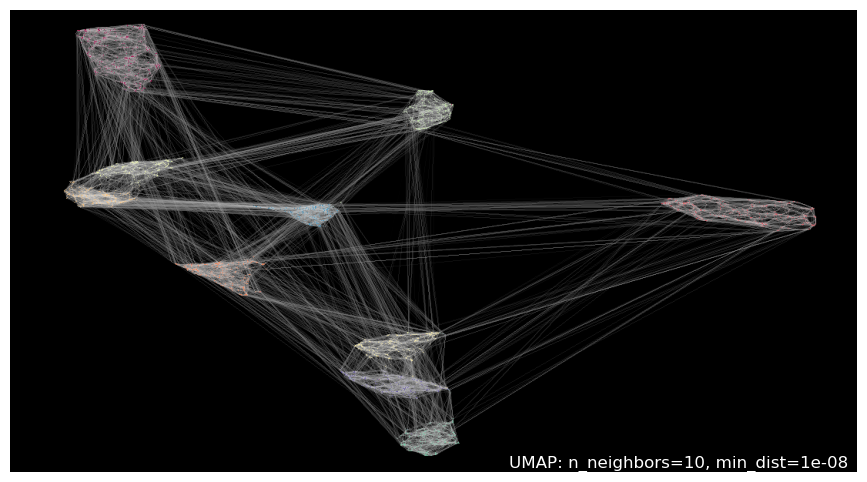

In [35]:
import umap.plot
umap.plot.connectivity(umap_mapper, show_points=True, labels=targets, width=1100, height=600, theme='inferno')
plt.savefig('umapgraph_talk.png',bbox_inches='tight')

In [35]:
umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data, n_components=2)

/disk/home/vmpouli/.conda/envs/high-dim-easydata/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [36]:
w13 = np.where(targets==13)[0]

In [37]:
w = [list(targets).index(i) for i in range(1,21)] + [w13[int(len(w13)/2)]]
bottomleft = [list(targets).index(i) for i in [1,6,7,8,10,11,12,13,14,15,16, 18,20]]
centertop = [list(targets).index(i) for i in [17, 5, 19]]
bottomright = [list(targets).index(i) for i in [2]]

In [38]:
what2plot = np.isin(targets, [11, 13, 16, 20])
umap_sub = umap_rep[what2plot]
targets_sub = targets[what2plot]

In [39]:
w_pic = list(targets).index(16)
filenames[w_pic]

'../data/coil-20-proc/obj16__0.png'

In [40]:
def plot_images(umap_rep, targets, filenames, image_file=None):
    #w13 = np.where(targets==13)[0]
    w = [list(targets).index(i) for i in range(1,21) if i in targets]
    for x in [13,11]:
        w2 = np.where(targets==x)[0]
        w.append(w2[int(len(w2)/3)])
    bottomleft = [list(targets).index(i) for i in [1,6,7,8,10,11,12,13,14,15,16, 18,20] if i in targets]
    centertop = [list(targets).index(i) for i in [17, 5, 19] if i in targets]
    bottomright = [list(targets).index(i) for i in [2] if i in targets]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    g = sns.scatterplot(x=umap_rep[:,0], y =umap_rep[:,1], s=5, legend=False, edgecolor='none')
    # g.set(xticklabels=[])
    # g.set(yticklabels=[])
    sns.scatterplot(x=umap_rep[w,0], y =umap_rep[w,1], s=25, legend=False, edgecolor='black', linewidth=1)

    for w_pic in w:
        image = filenames[w_pic]
        data = plt.imread(image)
        width=2
        if(w_pic in bottomleft):
            extent = (umap_rep[w_pic,0], umap_rep[w_pic,1], width, width)
        elif(w_pic in bottomright):
            extent = (umap_rep[w_pic,0]-width, umap_rep[w_pic,1], width, width)
        elif(w_pic in centertop):
            extent = (umap_rep[w_pic,0]-width/2, umap_rep[w_pic,1]-3/2*width, width, width)
            plt.plot([umap_rep[w_pic,0], umap_rep[w_pic,0]], [umap_rep[w_pic,1]-width/2,umap_rep[w_pic,1]], color='black')
        else:
            extent = (umap_rep[w_pic,0]-width, umap_rep[w_pic,1]-width, width, width)
        # plt.text(umap_rep[w_pic,0]-2, umap_rep[w_pic,1], s=str(targets[w_pic]))
        axin = ax.inset_axes(extent,transform=ax.transData)    # create new inset axes in data coordinates
        axin.imshow(data, cmap='gray',)
        axin.axis('off')
    sns.set_style(style='white')
    sns.despine(bottom = True, left = True)
    if(image_file is not None):
        plt.savefig(image_file,bbox_inches='tight')

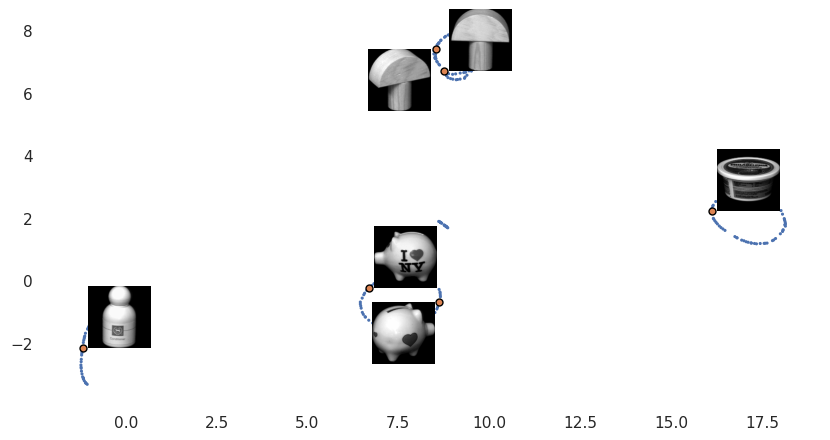

In [42]:
what2plot = np.isin(targets, [11, 13, 16, 20])
plot_images(umap_rep[what2plot], 
            targets[what2plot], 
            [f for i, f in enumerate(filenames) if what2plot[i]],
           'test3.png')

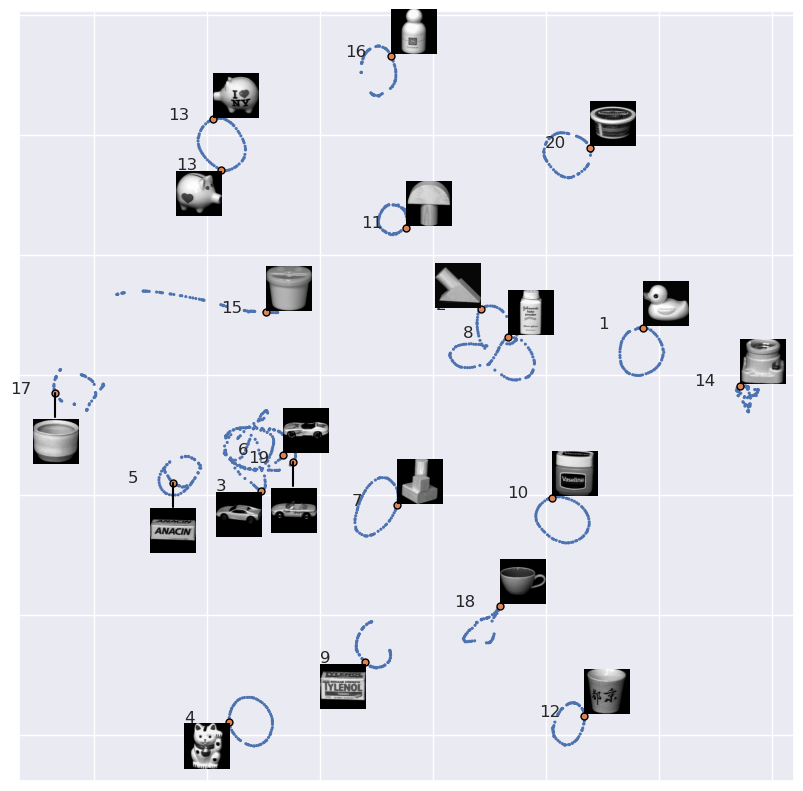

In [242]:
fig, ax = plt.subplots(figsize=(10, 10))
g = sns.scatterplot(x=umap_rep[:,0], y =umap_rep[:,1], s=5, legend=False, edgecolor='none')
g.set(xticklabels=[])
g.set(yticklabels=[])
# left, right = ax.get_xlim()
# bottom, top = ax.get_ylim()

sns.scatterplot(x=umap_rep[w,0], y =umap_rep[w,1], s=25, legend=False, edgecolor='black', linewidth=1)

for w_pic in w:
    image = filenames[w_pic]
    data = plt.imread(image)
    width=2
    if(w_pic in bottomleft):
        extent = (umap_rep[w_pic,0], umap_rep[w_pic,1], width, width)
    elif(w_pic in bottomright):
        extent = (umap_rep[w_pic,0]-width, umap_rep[w_pic,1], width, width)
    elif(w_pic in centertop):
        extent = (umap_rep[w_pic,0]-width/2, umap_rep[w_pic,1]-3/2*width, width, width)
        plt.plot([umap_rep[w_pic,0], umap_rep[w_pic,0]], [umap_rep[w_pic,1]-width/2,umap_rep[w_pic,1]], color='black')
    else:
        extent = (umap_rep[w_pic,0]-width, umap_rep[w_pic,1]-width, width, width)
    plt.text(umap_rep[w_pic,0]-2, umap_rep[w_pic,1], s=str(targets[w_pic]))
    axin = ax.inset_axes(extent,transform=ax.transData)    # create new inset axes in data coordinates
    axin.imshow(data, cmap='gray',)
    axin.axis('off')
plt.savefig('coil-projection.png')

In [14]:
from glob import glob
from PIL import Image
data_folder = '../data'
image_datas = []
for i in range(1, 4):
    directory = f"{data_folder}/sheffield_buildings/Dataset/{i}"
    all_images = [Image.open(filename) for filename in glob(f"{directory}/*")]
    image_datas = image_datas + [all_images[j] for j in range(0,24,4)]

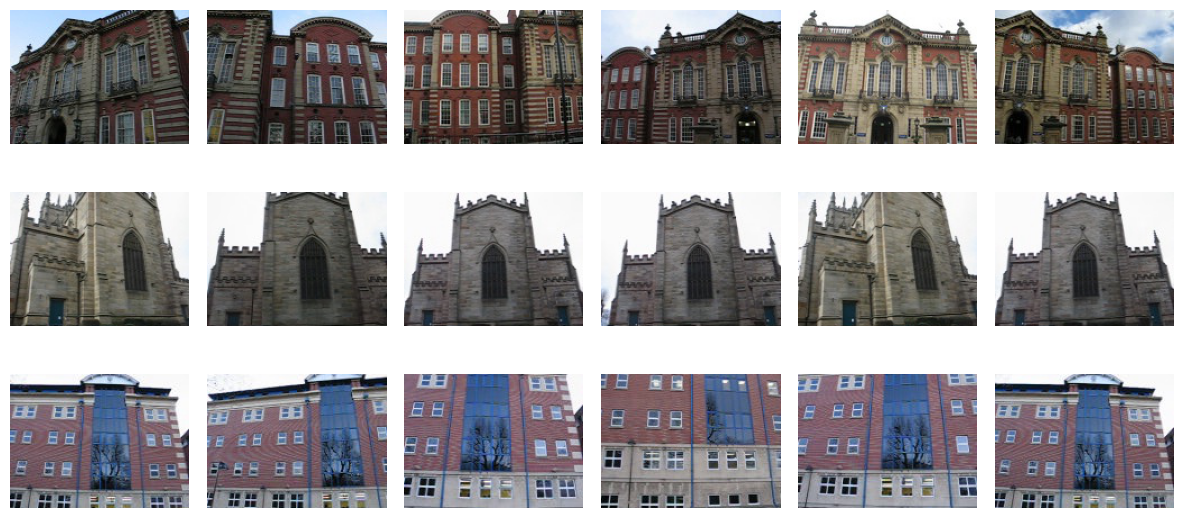

In [16]:
rc = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False,
     "axes.grid": False}
plt.rcParams.update(rc)
_, axs = plt.subplots(3, 6, figsize=(12, 6))
axs = axs.flatten()
for img, ax in zip(image_datas, axs):
    ax.imshow(img)
plt.gcf().tight_layout()
plt.savefig('figures/buildings.png')
plt.show()

In [78]:
G = knn_digraph(raw_data, 25).as_undirected()
G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
G = enrich_graph_edge_properties(G, 
                                 vertex_high_representation=raw_data)

### On full graph (fuzzy union)

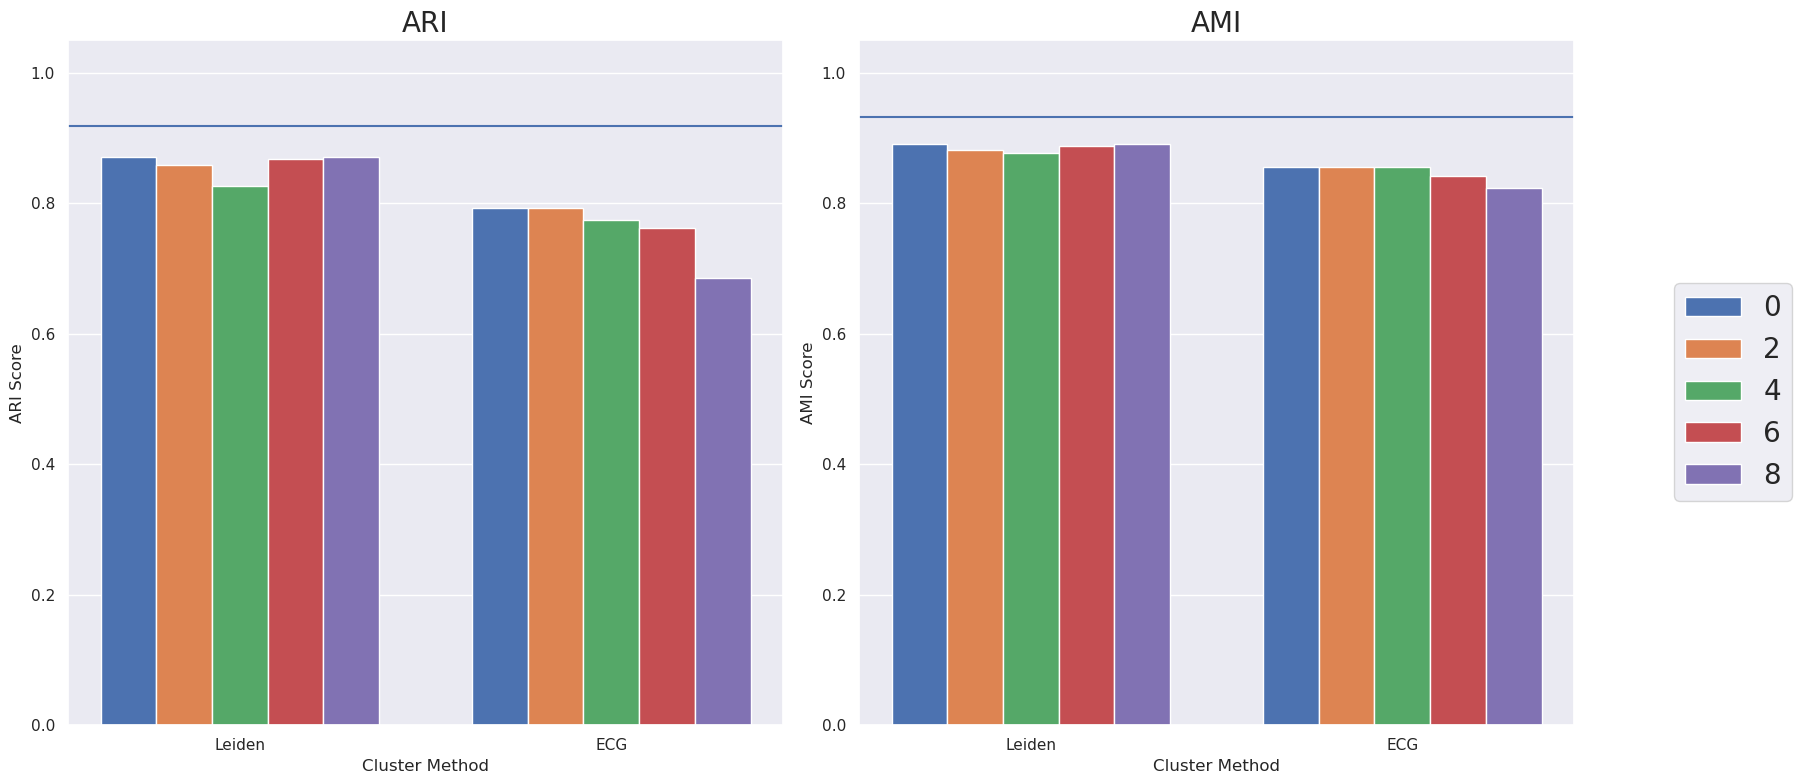

In [106]:
graph_results = []
for n_triangles in range(0, 10, 2):
    edges = [e for e in G.es if e['nb_triangles']>=n_triangles]
    G_sub = G.subgraph_edges(edges)
    clusterings, clustering_labels  = run_graph_clustering_algorithm(algo_list2, G_sub)
    graph_results_part = evaluation_dataframe(clustering_labels, targets, raw_data, min_cluster_size=5)
    graph_results_part = graph_results_part.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
    graph_results_part["Triangles"] = n_triangles
    graph_results.append(graph_results_part)

results = pd.concat(graph_results)
display(Markdown(f'### On full graph (fuzzy union)')) 
plot_scores(results, score_types=("ARI", "AMI"), by="Triangles", baselines=[ari, ami])
plt.show()

# Run the same analysis on all datasets

In [107]:
def what_we_do_here(dataset_id, verbose=True, noise=True, algo_list=algo_list, algo_list2=algo_list2):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))
    
    # On full graph (fuzzy union)
    umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
    hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)
    ari = adjusted_rand_score(targets, hd_umap_labels)
    ami = adjusted_mutual_info_score(targets, hd_umap_labels)
    G = knn_digraph(raw_data, 25).as_undirected()
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
    G = enrich_graph_edge_properties(G, 
                                     vertex_high_representation=raw_data)
    
    graph_results = []
    for n_triangles in range(0, 10, 2):
        edges = [e for e in G.es if e['nb_triangles']>=n_triangles]
        G_sub = G.subgraph_edges(edges)
        clusterings, clustering_labels  = run_graph_clustering_algorithm(algo_list2, G_sub)
        graph_results_part = evaluation_dataframe(clustering_labels, targets, raw_data, min_cluster_size=5)
        graph_results_part = graph_results_part.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
        graph_results_part["Triangles"] = n_triangles
        graph_results.append(graph_results_part)

    results = pd.concat(graph_results)
    display(Markdown(f'### On full graph (fuzzy union)')) 
    plot_scores(results, score_types=("ARI", "AMI"), by="Triangles", baselines=[ari, ami])
    plt.show()

## coil

/disk/home/vmpouli/.conda/envs/high-dim-easydata/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


### On full graph (fuzzy union)

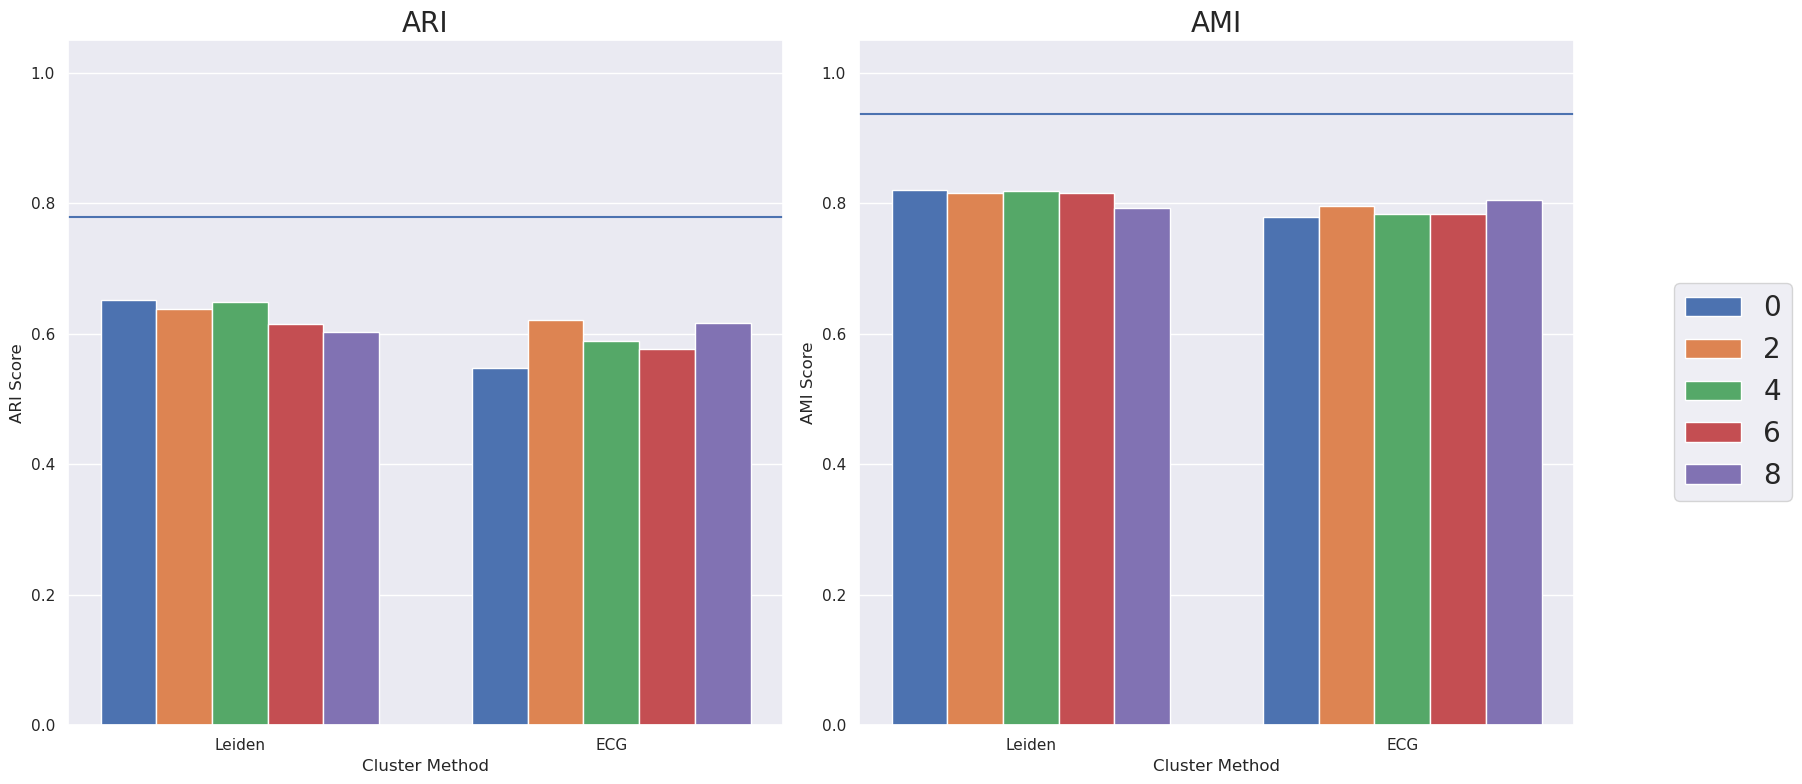

## mnist

ValueError: Found input variables with inconsistent numbers of samples: [35000, 34999]

In [108]:
for i in [1,2,3,4]:
    what_we_do_here(dataset_id=i)